In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os,shutil

# split the data by train/val/test
path = '/content/drive/My Drive/Deep Learning IITG/Project/Brain Tumor Detection/Brain Tumor CNN/archive/brain_tumor_dataset/'
img_path='/content/drive/My Drive/Deep Learning IITG/Project/Brain Tumor Detection/Brain Tumor CNN/archive/Dataset/'

for CLASS in os.listdir(path):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(path + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(path + CLASS)):
            img = path + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, img_path + 'TEST/'  + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, img_path + 'TRAIN/'  + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, img_path + 'VAL/'  + CLASS.upper() + '/' + FILE_NAME)

### Load the image data into Training dataset and Validation dataset

Since the dataset is classified into folders for their respective classes, keras.utils.image_dataset_from_directory method can be used to load and split the image data into training and validation datasets.

This method takes care of the following steps:
1. Loads the images from the disk
2. Converts the .jpg files into floating point tensors of RGB pixel values

This method does not perform
1. Standardization or Normalization which has to be performed separately. Standardization is mean subtraction and SD division. Normalization is dividing each value with the total sum so as to have range of values between 0 and 1

Here while performing the splits, the shuffle parameter is set to True for training and False to validation just to have uniformity when spliting the validation data into vaidation and test splits. Though it is True for training and False for validation dataset, the data will not be duplicated as the shuffle is only performed on the subset of data which is split based on the validation_split parameter. The data is first split into 70% and 30% and later the shuffle operation is performed on the individual subset of data

In [3]:
import tensorflow as tf
import numpy as np

train_ds = tf.keras.utils.image_dataset_from_directory(img_path + 'TRAIN',
                                                      labels='inferred',
                                                      label_mode = 'binary',
                                                      batch_size = 16,
                                                      image_size = (224,224),
                                                      shuffle=True,
                                                      seed =42)

val_ds = tf.keras.utils.image_dataset_from_directory(img_path + 'VAL',
                                                      labels='inferred',
                                                      label_mode = 'binary',
                                                      batch_size = 16,
                                                      image_size = (224,224),
                                                      shuffle=False,
                                                      seed =42)

test_ds = tf.keras.utils.image_dataset_from_directory(img_path + 'TEST',
                                                      labels='inferred',
                                                      label_mode = 'binary',
                                                      batch_size = 16,
                                                      image_size = (224,224),
                                                      shuffle=False,
                                                      seed =42)

Found 193 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 10 files belonging to 2 classes.


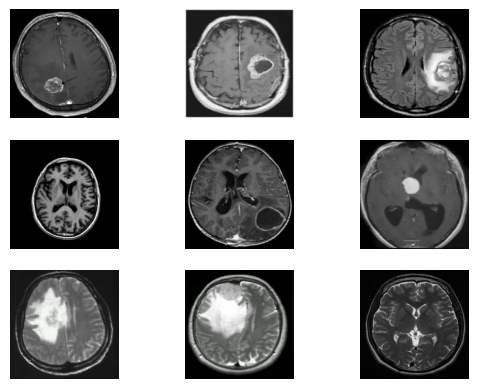

In [4]:
import matplotlib.pyplot as plt

for images,labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.axis('off')
  plt.show()

### Using VGG16 pretrained model

It is most common and efficient approach to use a pretrained model to train small datasets. This provides 2 options,

1. Feature extraction: Pretrained Conv models have 2 components, Convolution base and the Densly connected classifier. The ConvBase will have the spatial hierarchical details of the images which can be reused upon a new set of data as the learnt features are translation invariant. The early layers having learnt the local details such as edges,colors and so on while the top layers having learnt the hierarchical details such as cats ear, eyes and so on. The densly connected classifier block will the specific to the problem in hand like looking for this or that object from image. So it is best not to reuse the Densly connected classifier block

Few points to keep in mind while performing Feature Extraction:

  a. Freeze the convbase while training the network so that the weights remain untouched.
  
  b. Only train the Densly connected classifier block so only weights from this block is learnt


2. Fine tuning: This is another common approach with model reuse, where a part of the convbase is unfreezed for training to make the model more relevant to the problem in hand.

The weights parameters can have the following attributes

1. imagenet: indicates to use the learnt pretrained weights. Used for transfer learning and feature extraction
2. None: indicates to initalize the weights randomly. Used when training from scratch or for experimenting

In [5]:
from keras.applications import VGG16
from keras import layers,models
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import Adam

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
conv_base.trainable = False

data_augmentation = models.Sequential([layers.RandomFlip('horizontal'),
                                      layers.RandomRotation(0.1),
                                      layers.RandomFlip(0.1),
                                      layers.RandomZoom(0.1),
                                      layers.RandomContrast(0.1),
                                      layers.RandomShear(0.1)])

inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)

model = models.Model(inputs,outputs)

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25088)     │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │     25,089 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

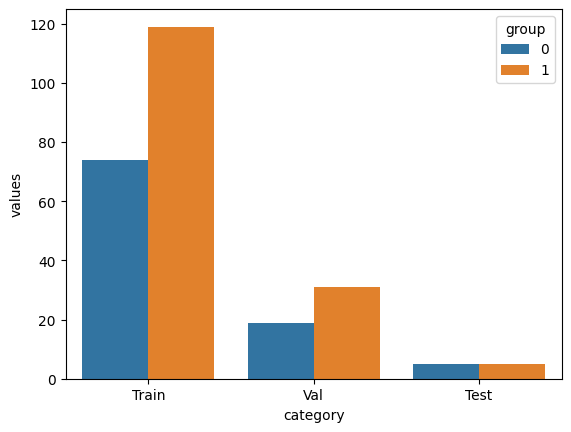

In [7]:
#Visualize class imbalance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels = np.concatenate([y.numpy().flatten() for _,y in train_ds])
val_labels = np.concatenate([y.numpy().flatten() for _,y in val_ds])
test_labels = np.concatenate([y.numpy().flatten() for _,y in test_ds])

data = {'group' : [0,1,0,1,0,1],
        'category' : ['Train','Train','Val','Val','Test','Test'],
        'values' : [len(labels)-np.count_nonzero(labels),np.count_nonzero(labels),
                    len(val_labels)-np.count_nonzero(val_labels),np.count_nonzero(val_labels),
                    len(test_labels)-np.count_nonzero(test_labels),np.count_nonzero(test_labels)]}

df = pd.DataFrame(data)

sns.barplot(x='category',y='values',hue='group',data=df)
plt.show()

Since the dataset is imbalanced, added class weights to ensure the model penalizes heavily for the wrong predictions on the minority class

In [8]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_acc',mode='max',patience=5,restore_best_weights=True)
class_0_counts = np.count_nonzero(labels==0)
class_1_counts = np.count_nonzero(labels==1)
class_0_weights = len(labels)/(2*class_0_counts)
class_1_weights = len(labels)/(2*class_1_counts)

history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=[earlystopping],
                    class_weight={0:class_0_weights,1:class_1_weights})


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.5351 - loss: 5.3717 - val_accuracy: 0.6400 - val_loss: 2.0427
Epoch 2/20
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5000 - loss: 6.0330

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5918 - loss: 4.4023 - val_accuracy: 0.7400 - val_loss: 1.6196
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6327 - loss: 4.0101 - val_accuracy: 0.8200 - val_loss: 1.5741
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6944 - loss: 3.3517 - val_accuracy: 0.8200 - val_loss: 1.5597
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6934 - loss: 2.9453 - val_accuracy: 0.8200 - val_loss: 1.7041
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7535 - loss: 2.3070 - val_accuracy: 0.8200 - val_loss: 1.7240
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7578 - loss: 2.0969 - val_accuracy: 0.8200 - val_loss: 1.5231
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8234 - loss: 1.8510 - val_accuracy: 0.8000 - val_loss: 1.8229
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.7322 - loss: 1.8961 - val_accuracy: 0.8200 - val_loss: 1

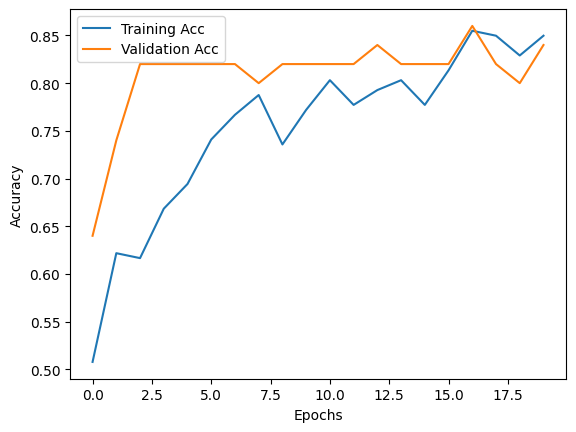

In [9]:
plt.plot(history.history['accuracy'],label='Training Acc')
plt.plot(history.history['val_accuracy'],label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

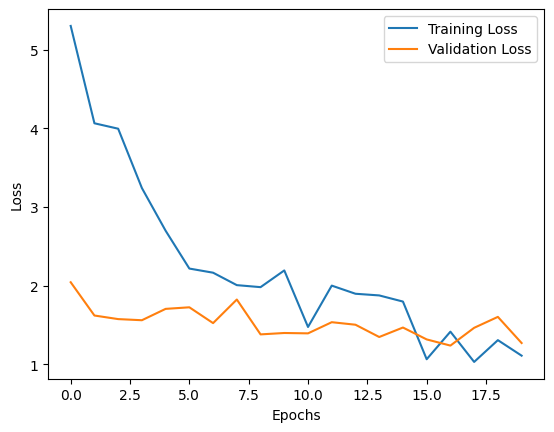

In [10]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
images_list=[]
labels_list=[]

for images,labels in val_ds:
  images_list.append(images)
  labels_list.append(labels)

images = tf.concat(images_list,axis=0)
labels = tf.concat(labels_list,axis=0)

val_pred = model.predict(images)



2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [12]:
val_pred = [1 if x>0.5 else 0 for x in val_pred]

In [13]:
from sklearn.metrics import accuracy_score

validation_acc = accuracy_score(labels,val_pred)
print(f'Validation Accuracy: {validation_acc}')

Validation Accuracy: 0.84


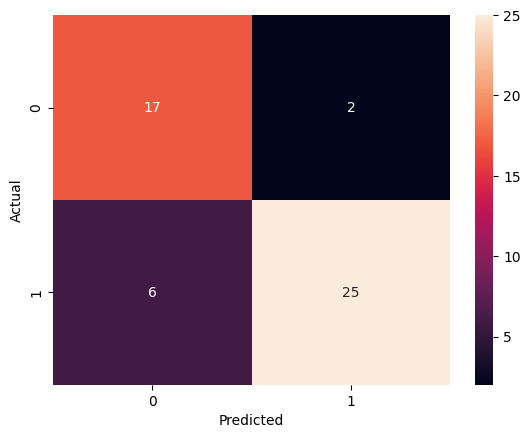

In [14]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(labels,val_pred)
sns.heatmap(confusion_mat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
test_images = []
test_labels = []
for images,labels in test_ds:
  test_images.append(images)
  test_labels.append(labels)

test_img = tf.concat(test_images,axis=0)
test_truth = tf.concat(test_labels,axis=0)

test_pred = model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [17]:
test_pred = [1 if x>0.5 else 0 for x in test_pred]

In [18]:
test_accuracy = accuracy_score(test_truth,test_pred)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.9


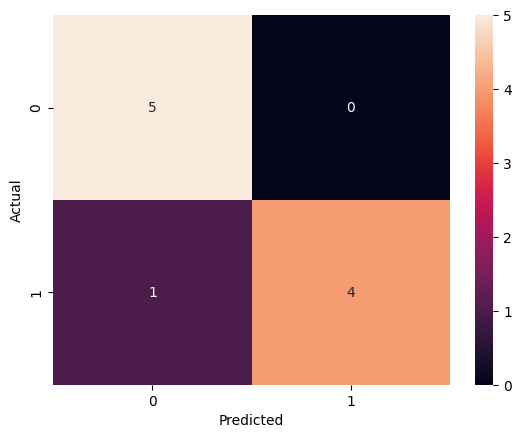

In [19]:
test_cm = confusion_matrix(test_truth,test_pred)
sns.heatmap(test_cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()